In [181]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


from math import pi
pd.options.mode.chained_assignment = None 

## Up Next: A comparison of modeling frameworks for developing a song recommendation system
#### Beck Addison

STA 325

# Introduction

The popularity of music streaming services in recent years has driven out previous players in the market of music distribution to become the highest grossing distribution medium of any previous form in history. As of 2019, the global market for music streaming was valued at $20.9 billion dollars and is expected to grow at a 17.8% compound annual growth rate over the 2020-2027 period (). However, this rapid growth combined with widespread consumption has driven major platforms such as Spotify and Apple Music (to name a few) to compete in what has effectively become a commodity market, where sellers are in a race to the most narrow profit margins in order to outsell their many competitors. The strategy for several of these services, such as the aforementioned Apple Music but also smaller players including YouTube Music (owned by Google) and Amazon Music Unlimited, is to use the parent organization's other revenue streams to subsidize free tier benefits that entice users to purchase a subscription, often at a loss or near-loss to the service itself.

Spotify, on the other hand, has made solid if small profit on a large operating income, and represents a staggering 27 percent of recorded music revenues globally (Prey 2020). Given that they operate independently of any parent company, Spotify has found an edge in their extensive reliance on recommendation algorithms, best illustrated by their development of an autogenerated "New Music Friday" playlist and also their on-the-fly "radio" generation button, where a user can generate a unique list of stylistically similar songs to any given song by simply clicking a button. While other services have now caught on to this trend, Spotify continues to pioneer creative methods to utilize user data effectively.

In this project, three methods are compared for effective classification of an individual's song preferences using a combined analysis of Spotify's "Audio Features", a set of quantified indicators collected by Spotify for every song in their database. These models will attempt to effectively predict which songs the user likes based in a similar way to Spotify's own recommendation system. These methods include a Random Forest model, a K Neighbors Classifier, and a Logistic Regression. Each method will be compared against the others for performance, and the best model will be chosen based on the 

# Data

In [182]:
songs = pd.read_csv('data.csv').drop('Unnamed: 0', axis = 1)

All of the recommendation models will be trained on the songs available in the Spotify Song Attributes dataset, available on [Kaggle](https://www.kaggle.com/geomack/spotifyclassification). This dataset contains a total of 2,017 songs with the following features associated with each observation (Unless otherwise noted, descriptions sourced from the [Spotify Developer Documentation](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features)):

- **acousticness** *(a continuous float on `[0.0, 1.0]`)*: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **danceability** *(a continuous float on `[0.0, 1.0]`)*: How suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **duration_ms** *(a continuous integer on [0, $+\infty$))*: The duration of the track in milliseconds.
- **energy** *(a continuous float on `[0.0, 1.0]`)*: A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
- **instrumentalness** *(a continuous float on `[0.0, 1.0]`)*: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
- **key** **(an ordinal integer on [-1, 11])**: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C(sharp)/D(flat);, 2 = D, and so on. If no key was detected, the value is -1.
- **liveness** *(a continuous float on [0.0, 1.0])*: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
- **loudness** *(a continuous float on [-60.0, 0.0])*: The overall loudness of a track in decibels (dB). 
- **mode** *(a nominal integer in {0, 1})*: Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
- **speechiness** *(a continuous float on [0.0, 1.0])*: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
- **tempo** *(a continuous float on [0, $+\infty$))*: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- **time_signature** *(an ordinal integer on [3, 7])*: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".
- **valence** *(a continuous float on [0.0, 1.0])*: The musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

Additional variables listed on this dataset not included in the Spotify Developer Documentation include:

- **song_title** *(a nominal string)*: the title of the song as listed on Spotify.
- **artist** *(a nominal string)*: The primary artist of the song as listed on Spotify.
- **target** (an ordinal integer in {0, 1}): A label placed on the data by the curator of the dataset. This value represents the response label for this project, and indicates whether he liked the song or not.

## Exploratory Data Analysis

First and foremost, we can intuit that there is likely some amount of correlation between the song attributes. This is illustrated below:

<AxesSubplot:>

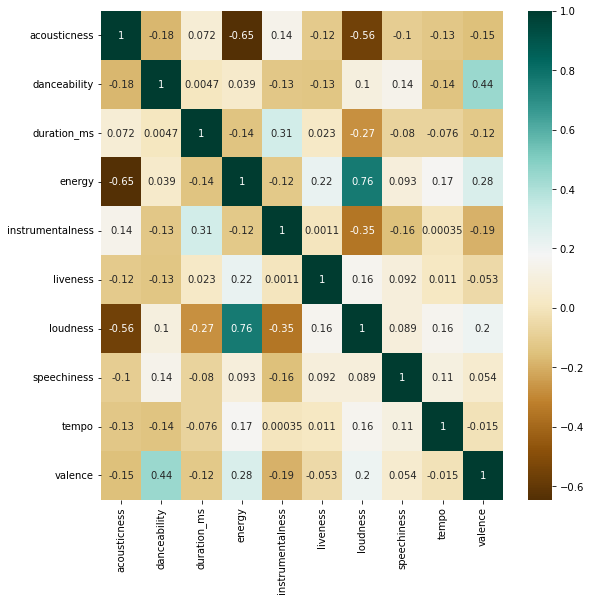

In [183]:
songs_attributes = songs.iloc[:, 0:13]
songs_cat_attrs = songs_attributes[['key', 'mode', 'time_signature']]
song_num_attrs = songs_attributes.drop(['key', 'mode', 'time_signature'], axis = 1)
plt.figure(figsize = (9, 9))
sns.heatmap(song_num_attrs.corr(), annot=True, cmap = 'BrBG')

Some of the notable stand-outs here include energy and acousticness (a strong negative correlation) and energy and loudness (a strong positive correlation). This makes intuitive sense - an acoustic track is likely to be slower in tempo and energy and certainly not be very loud. In contrast, songs with high valence appear to have a similarly high energy and loudness, pointing to their upbeat, positive nature.

As mentioned previously, this user encoded a variable called `target` that is 1 to denote a liked song and 0 to denote a song that was not liked. We can see in the plot below how the liked songs compared to unliked songs when considering these song attributes:

Text(0.5, 1.0, 'Distribution of (scaled) features for unliked and liked songs')

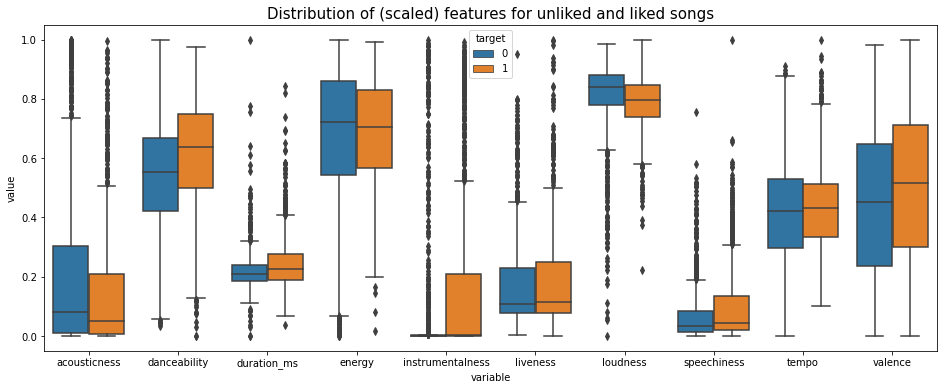

In [184]:
from sklearn.preprocessing import MinMaxScaler
plt.figure(figsize=(16, 6))

mm = MinMaxScaler()
vals = songs.iloc[:, 0:14].drop(['key', 'mode', 'time_signature', 'target'], axis = 1)
X = pd.DataFrame(mm.fit_transform(vals.to_numpy()), columns = vals.columns)
X['target'] = songs['target']
X = X.melt(id_vars = 'target')

sns.boxplot(data = X, x = 'variable', y = 'value', hue = 'target')
plt.title('Distribution of (scaled) features for unliked and liked songs', size = 15)


From above, it appears that this individual prefers songs that are typically not very acoustic but very danceable and with high valence, compared to unliked songs. Likewise, he appears to like songs with higher instrumentalness than in unliked songs. However, it should be noted that, for the most part, his preferences fall in line with the available music in the dataset. This could be comparable to someone who prefers very pop-centric, of-the-moment songs that are easy to dance to and are high energy. Another way of visualizing this is given below:

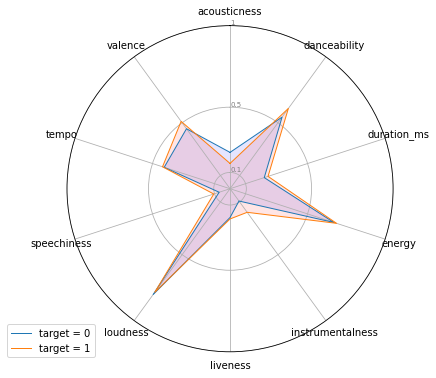

In [185]:
# Set data
df = X.groupby(['target', 'variable']).mean().reset_index().pivot(index = 'target', columns = 'variable', values = 'value').reset_index()
# ------- PART 1: Create background
plt.figure(figsize=(8, 6))
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.5,1], ["0.1","0.5","1"], color="grey", size=7)
plt.ylim(0,1)
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.loc[0].drop('target').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="target = 0")
ax.fill(angles, values, 'b', alpha=0.1)
 
# Ind2
values=df.loc[1].drop('target').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="target = 1")
ax.fill(angles, values, 'r', alpha=0.1)
 
# Add legend
plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()


Finally, we can see that the number of liked to unliked songs is roughly equal - the dataset is thankfully not imbalanced with respect to the response label:

<AxesSubplot:xlabel='target', ylabel='count'>

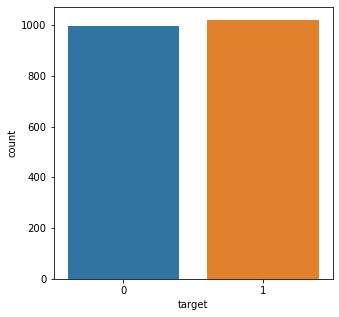

In [186]:
plt.figure(figsize=(5,5))
sns.countplot(data = songs, x = 'target')

## Encodings and Transformations

To prepare the data for processing, I passed it through the following encoders:

1. An ordinal encoder of the `mode`, `key`, and `time_signature` variables - this allows the modeling functions to see these variables as ordered categorical (ordinal) variables rather than as continuous variables.
2. Scaling of the numerical attributes - I scaled and centered the numerical song attributes using the `sklearn` package's `MinMaxScaler`. This was particularly important for variables such as `tempo` and `loudness` - otherwise their impact could be misunderstood by the model relative to other variables.
3. A one hot encoder of the `song_title` and `artist` variables, so that they could be properly examined by the various regression methods used.

In addition, the data was split into a test and training set, on a 30-70 test-train percentile split.

# Methodology

The following regression methods were chosen to predict the outcome of `target`: A random forest classifier, A logistic regression model, and a k-nearest neighbors classifier. Grid search with 10-fold cross-validation was performed on each of the models' tuning parameters and scoring on Accuracy and ROC AUC (see the table below), and the best model of each of the model classes was chosen for comparison (see Results). These three algorithms were chosen based on their intuitiveness and simplicity, as well as their relevance to the context of the data itself. 

To some degree, we have the underlying prior belief that there is some clustering that is occurring in the dataset - this person's tastes in music are likely to be consistent, and therefore he's more likely to prefer songs similar to other songs he's liked than he is to prefer songs he didn't like before. This is the underlying intuition of K-nearest neighbor models - that points around a given point are likely to be in the same class as that given point, compared to points further away. In addition, since the concept of "nearness" is very broad (Euclidean distance is traditional, but truly any type of measurement of closeness between two points works), it allows for a lot of flexibility and experimentation to perform a grid-search with. Finally, K-nearest neighbors is easy to understand - this is particularly important when conveying results to people who are not familiar with a more complicated modeling algorithm.

Like the KNN classifier, the random forest classifier is useful in large part because it is fairly easy to understand when the number of trees in the set are fairly low; while it is more complicated than simply picking the nearest points to a given point, an RF classifier is also very fast to compute and scales remarkably well to accomodate more data. In addition, RF classifiers like this are robust to outliers, and from the boxplot shown above, it appears that there may be a fair amount of outliers in both classes. One drawback is that it is not as interpretable at scale (i.e. as the number of trees grows); thus, while I expect this model to be more accurate than the KNN model, on the spectrum of interpretability established by these models, the RF is probably the least interpretable.

Finally, the logistic regression model was chosen to act as a deviation from the typical set of categorical classifiers. Since we are trying to provide the user with songs he will like, the idea behind this model, that we can give the odds he'll like it, is perfect to consider the problem from less binary perspective. The previous two models provide an answer that states "you will like the song" or "you won't like the song" based on the data, whereas the logistic model can answer the question of whether he will like the song with an answer that is more nuanced. From a technical perspective, the logistic regression model is also very easy to train and, if explained properly, has a very convenient tabular representation with coefficients that can help to explain the individual effects of the predictors on the models.

The Grid Search parameters used for the KNN and RF models were specified as follows:

##### K-nearest neighbors Classifer:

- K: $[0, 1, \ldots, 15]$
- weights: 'distance', 'uniform'

##### Random Forest Classifier:

- N (number of trees): $[64, 65, \ldots, 128]$. This range of trees seems arbitrary, but was educated by the explanation in (Baranauskas 2012) of an optimal tradeoff between ROC and runtime.
- Max Depth (the number of levels in the tree): $[1, 2, \ldots, 5]$
- Minimum Sample Split (how many samples required to split a branch/node into two children): $[2, 4, 6, \ldots, 20]$

# Results

In [330]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler

cat_attrs = ["key", "mode", "time_signature", "song_title", "artist"]
num_attrs = songs.drop(cat_attrs + ["target"], axis=1).columns
X = songs.drop("target", axis=1)
y = songs["target"]

MM = MinMaxScaler()
OE = OrdinalEncoder()
X[cat_attrs] = OE.fit_transform(X[cat_attrs])
X = pd.DataFrame(MM.fit_transform(X), columns = X.columns)

LE = LabelEncoder()
y = LE.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=150
)



In [311]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

In [333]:
# KNN
KNN = KNeighborsClassifier()
gs_KNN = GridSearchCV(
    KNN,
    param_grid={'n_neighbors': np.arange(np.log(X_train.shape[0]).astype(int), (10*np.log(X_train.shape[0])).astype(int))},
    cv=10,
    n_jobs=-1,
    refit='AUC',
    scoring = scoring,
    return_train_score=True
)
gs_KNN.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71])},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc',
                      'Accuracy': make_scorer(accuracy_score)})

In [335]:
# RF
# TODO: BE CAREFUL RUNNING THIS, IT TAKES FOREVER!!!!!!!
RF = RandomForestClassifier()
gs_RF = GridSearchCV(
    estimator=RF,
    param_grid={
        "n_estimators": np.arange(64, 128),
        "max_depth": np.arange(1, 5),
        "min_samples_split": np.arange(2, 20, 2),
    },
    cv=10,
    n_jobs=-1,
    return_train_score=True
)
gs_RF.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': array([1, 2, 3, 4]),
                         'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                         'n_estimators': array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127])},
             return_train_score=True)

In [336]:
# LogReg
LR = LogisticRegression(max_iter = 10_000)
LR.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

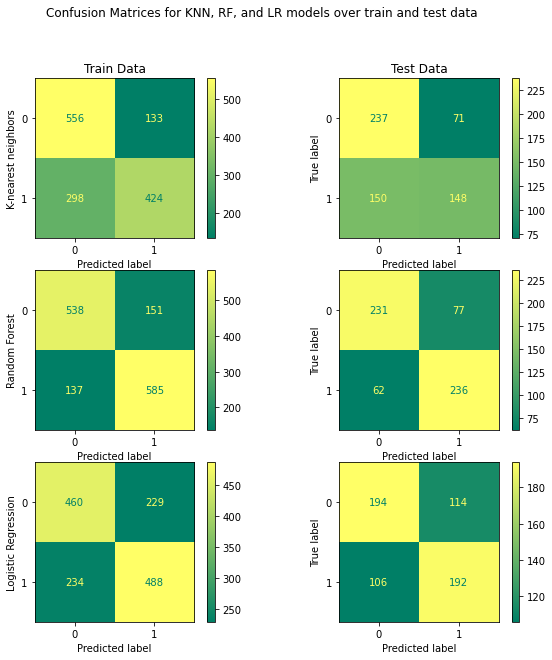

In [337]:
from sklearn.metrics import plot_confusion_matrix

models = (gs_KNN, gs_RF, LR)
titles = ('K-nearest neighbors', 'Random Forest', 'Logistic Regression')

fig, axs = plt.subplots(3, 2)
fig.set_figwidth(10)
fig.set_figheight(10)
plt.suptitle('Confusion Matrices for KNN, RF, and LR models over train and test data')
for i, (title, model) in enumerate(zip(titles, models)):
    for j, (X, y) in enumerate(zip([X_train, X_test], [y_train, y_test])):
        plot_confusion_matrix(model, X, y, ax = axs[i, j], cmap='summer')


for ax, row in zip(axs[:, 0], titles):
    ax.set_ylabel(row)

for ax, col in zip(axs[0, :], ['Train Data', 'Test Data']):
    ax.set_title(col)

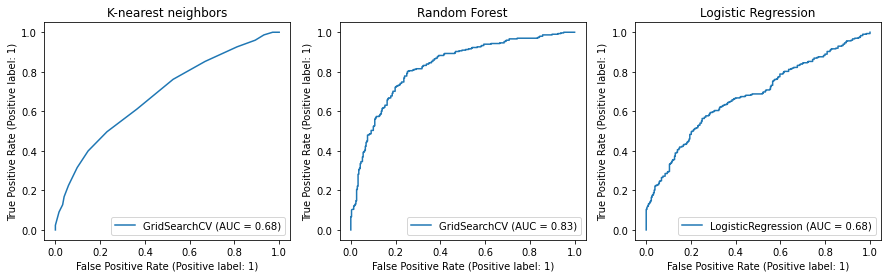

In [339]:
from sklearn.metrics import roc_curve, plot_roc_curve
fig, axs = plt.subplots(1, 3)
fig.set_figwidth(15)

for i, (title, model) in enumerate(zip(titles, models)):
    try:
        y_score = model.decision_function(X_test)
    except:
        y_score = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label = model.classes_[1])
    plot_roc_curve(model, X_test, y_test, ax = axs[i])

for ax, col in zip(axs, titles):
    ax.set_title(col)

From the results above, we can see that our Random Forest model had the highest accuracy. In the first chart, we see the confusion matrices produced for both training data and testing data - notice that, for the K-nearest neighbor model, the rate of false negatives is much higher than the rate of false positives, meaning that the KNN model is conservative in its confirmation of what songs our subject likes; meanwhile, the logistic regression model has a fairly balanced false positive/false negative rate, with similar overall accurace. This is reinforced by the ROC plot above - with an AUC of 0.68, they can accurately predict this individual's song preferences about 68% of the time for both of the models - keep in mind, however, that the distribution of the types of wrong answers will be different between the two models, as explained previously. However, in the context of the problem, neither model is very impressive - both are only slightly better than flipping a coin to decide whether he likes the song or not. Regardless, both models fail to meet the performance of the Random Forest model, which correctly classifies the outcome 83% of the time. Let us take a deeper look at this model.

The first important thing to examine with this model is the feature importance of each of our variables of concern. This will help to elucidate what decisions, conscious or unconscious, this individual is making to choose whether he likes or doesn't like a song.

In [341]:
from sklearn.inspection import permutation_importance

results = permutation_importance(
    gs_RF, X_test, y_test, n_repeats=10, random_state=150, n_jobs = -1
)

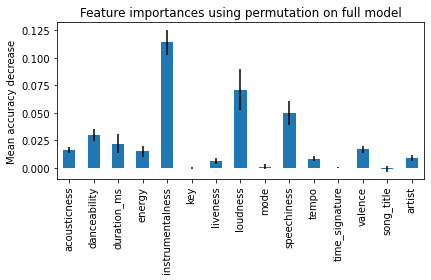

In [345]:
importances = pd.Series(results.importances_mean)
fig, ax = plt.subplots()
importances.plot.bar(yerr=results.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
ax.set_xticklabels(X.columns)
fig.tight_layout()
plt.show()

From this, it appears that none of the variables are particularly powerful in increasing accuracy individually, but that among those features, the instrumentalness of the song is most impactful (even then, it was only responsible for a 0.100 to 0.125 mean reduction in accuracy). This comes at no surprise - in the boxplot displayed in the Data section, we saw that there was a notable difference in the instrumentalness of the songs he liked, versus the songs he didn't. Other important features included the speechiness and loudness of the song, while features like the key didn't make a noticeable difference in his decision making.

# Conclusion

The results of the modeling procedure indicated that, for the construction of a recommender system using previously collected "liked" songs data, a random forest or otherwise tree-based process is probably best. There is a strong and valid argument that there exist multiple interaction terms, which forests are excellent at discovering, even if it isn't necessarily visible in the feature importance analysis (Wright, Ziegler and Konig 2016). This would naturally confuse a K-nearest neighbor model, which is looking for clear separations along the given parameter space (which didn't include interaction terms). In addition, one of the key drivers of song performance is the complex application of melodies, harmonies, and effective lyrics - concepts that, at least currently, are almost impractically difficult to boil down into a quantifiable value for a model to infer upon. In a study by Rentfrow, Goldberg and Levitin (2011), similar results were shown in predicting what songs subjects preferred based on the features of the song - only moderate correlations were established, but the researchers also noted that there were certain qualities of the music, notably social qualities, that weren't captured as part of the study. The same is true here, and thus we can only recognize that we have an imcomplete picture of a very complex psychology.

While this project demonstrated a moderately accurate random forest-based model for predicting song preference, this project serves as a more effective demonstration of the complexity of even simple concepts such as the decomposition of a song into its component parts. Further study into these concepts could work to reveal what drives human musical preference and even help us discover how we write songs to be preferable, opening up doors to the generation of likable music by machine learning or other algorithms from the field of artificial intelligence. 